### Load libraries

In [1]:
import dataclasses
from typing import Dict, List, Optional, Tuple, Union
import warnings

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import mlflow
import mlflow.keras

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from art.data_generators import TensorFlowV2DataGenerator
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.trainer import AdversarialTrainer

tf.config.list_physical_devices(device_type=None)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import sys
sys.path.append("../..")

from adversarial_ntks import dataset

### Load data

In [5]:
%%time

MNIST_TRAIN = dataset.get_np_data(name="mnist", split="train", agg_labels=((0,1,2,3,4),(5,6,7,8,9)))
MNIST_TEST = dataset.get_np_data(name="mnist", split="test", agg_labels=((0,1,2,3,4),(5,6,7,8,9)))

print(MNIST_TRAIN.xs.shape, MNIST_TRAIN.xs.min(), MNIST_TRAIN.xs.max())
print(MNIST_TEST.xs.shape, MNIST_TEST.xs.min(), MNIST_TEST.xs.max())

(60000, 784) 0.0 1.0
(10000, 784) 0.0 1.0
CPU times: user 11.8 s, sys: 17.4 s, total: 29.2 s
Wall time: 7.05 s


[0 0 0 1 1 0 0 1 0 1]


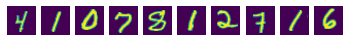

[0 0 0 1 1 1 0 1 0 0]


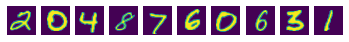

In [7]:
dataset.plot_images(MNIST_TRAIN, channels=1)
dataset.plot_images(MNIST_TEST, channels=1)

### Experiment setup

In [8]:
def untensor_dict(d: Dict) -> Dict:
    return {
        k: float(v) if isinstance(v, tf.Tensor) else v
        for k, v in d.items()
    }

def out_to_dict(out: Tuple, model: keras.Model, prefix: str) -> Dict:
    return untensor_dict({
        f"{prefix}_{k}" : v
        for k, v
        in zip(model.metrics_names, out)
    })

def fmt_dict(d: Dict) -> str:
    dd = {
        k: f"{v : .4f}" if isinstance(v, float) else v
        for k, v in d.items()
    }
    return str(dd)

def mlflow_log_np(a: np.ndarray, name: str):
    """name should not include .npy"""
    np.save(f"tmp-artifacts/{name}.npy", a)
    mlflow.log_artifact(f"tmp-artifacts/{name}.npy")

In [9]:
@dataclasses.dataclass
class ExperimentParams:
    ds_train: dataset.Dataset  # not one hot
    ds_test: dataset.Dataset   # not one hot
    num_fourier_features: int
    kernel_scale: float
    kernel_type: str
    train_epochs: int
    adv_ratio: float  # in [0, 1]; 0 = nat. training; 1 = full adv. training
    use_pgd: bool
    attack_norm: Union[float, int]
    attack_eps: float
    attack_eps_step: float
    attack_iters: int
    num_eval_per_epoch: int  # How many samples to use during evaluation
    batch_size: int
    learning_rate: int
    seed: int = 42
    
    def __post_init__(self):
        assert self.ds_train.num_classes == 2
        assert self.ds_test.num_classes == 2
        assert not self.ds_train.one_hot
        assert not self.ds_test.one_hot
    
    def to_mlflow_dict(self) -> Dict:
        ret = dataclasses.asdict(self)
        
        del ret["ds_train"]
        del ret["ds_test"]
        
        ret["ds_train_name"] = self.ds_train.name
        ret["ds_test_name"] = self.ds_test.name
        
        return ret

    
def run_experiment(
    params: ExperimentParams,
    print_every: Optional[int] = None,
    verbose: bool = False,
):
    """
    Keras code derived from https://keras.io/examples/vision/mnist_convnet/.
    
    ART code derived from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    and https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238.
    """
    mlflow.log_params(params.to_mlflow_dict())
    np.random.seed(params.seed)
    tf.random.set_seed(params.seed)
    
    DS_TRAIN = params.ds_train.to_one_hot()
    DS_TEST = params.ds_test.to_one_hot()
    DATA_SHAPE = DS_TRAIN.xs[0].shape
    
    class ExperimentCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch: int, logs: Dict):
            logs = untensor_dict(logs)
            if epoch % print_every == 0:
                print(f"Epoch {epoch} finished; Evaling...", end=" ")
            
            ds_sub_train = DS_TRAIN.subsample(params.num_eval_per_epoch)
            ds_sub_test = DS_TEST.subsample(params.num_eval_per_epoch)
            
            xs_sub_train_pgd = art_pgd_attack.generate(x=ds_sub_train.xs, y=ds_sub_train.ys)
            xs_sub_test_pgd = art_pgd_attack.generate(x=ds_sub_test.xs, y=ds_sub_test.ys)
            
            sub_train_nat_out = model.evaluate(ds_sub_train.xs, ds_sub_train.ys, verbose=0)
            sub_test_nat_out = model.evaluate(ds_sub_test.xs, ds_sub_test.ys, verbose=0)
            
            sub_train_pgd_out = model.evaluate(xs_sub_train_pgd, ds_sub_train.ys, verbose=0)
            sub_test_pgd_out = model.evaluate(xs_sub_test_pgd, ds_sub_test.ys, verbose=0)
            
            mlflow.log_metrics(out_to_dict(prefix="sub_train_nat", out=sub_train_nat_out, model=model))
            mlflow.log_metrics(out_to_dict(prefix="sub_train_pgd", out=sub_train_pgd_out, model=model))
            mlflow.log_metrics(out_to_dict(prefix="sub_test_nat", out=sub_test_nat_out, model=model))
            mlflow.log_metrics(out_to_dict(prefix="sub_test_pgd", out=sub_test_pgd_out, model=model))
            mlflow.log_metrics(logs)
            
            if epoch % print_every == 0:
                print(fmt_dict(logs))
                if verbose:
                    print(fmt_dict(out_to_dict(prefix="sub_train_pgd", out=sub_train_pgd_out, model=model)))
                    print(fmt_dict(out_to_dict(prefix="sub_test_pgd", out=sub_test_pgd_out, model=model)))
    
    def kernel_f(n):
        """
        Per https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/RandomFourierFeatures
        """
        if params.kernel_type.lower() == "gaussian":
            return np.exp(- n ** 2 / (2 * params.kernel_scale ** 2))
        elif params.kernel_type.lower() == "laplacian":
            return np.exp(- n / params.kernel_scale)
        else:
            raise NotImplementedError
        
    def delta(eps, norm: Union[int, float]):
        if norm == 2:
            return np.sqrt(2 * (kernel_f(0) - kernel_f(eps)))
        elif norm == np.inf:
            l2_eps = np.sqrt(eps * eps * np.prod(DATA_SHAPE))
            return np.sqrt(
                2 * (kernel_f(0) - kernel_f(l2_eps))
            )

    model : keras.Model = keras.Sequential([
        keras.layers.InputLayer(
            input_shape=DATA_SHAPE,
        ),
        layers.experimental.RandomFourierFeatures(
            output_dim=params.num_fourier_features,
            scale=params.kernel_scale,
            kernel_initializer=params.kernel_type,
            trainable=False,
        ),
        layers.experimental.preprocessing.Rescaling(
            scale=np.sqrt(2 / np.prod(DATA_SHAPE)),
            trainable=False,
        ),
        layers.Dense(units=1, use_bias=True),
    ])
        
    def hinge(y_true, y_pred):
        """y_true is one hot!"""
        assert y_true.shape[1] == 2
        assert y_pred.shape[1] == 1
        
        #y_true = tf.cast(y_true, tf.float32)
        return K.relu(
            1 - (y_true[:, 1] - y_true[:, 0]) * y_pred[:, 0]
            #1 - (2 * y_true - 1) * y_pred
        )
    
    delta_eps = 2*delta(eps=params.attack_eps, norm=params.attack_norm)
    print(f"delta(eps)={delta_eps:.6e}")
    def hinge_robust_ub(y_true, y_pred):
        """y_true is one hot!"""
        assert y_true.shape[1] == 2
        assert y_pred.shape[1] == 1
        y_true = tf.cast(y_true, tf.float32)
        
        W = model.layers[-1].kernel  # shape: (num_fourier_features, 1)
        W_norm = tf.norm(W, ord=2)
        
        y_pred_adv = y_pred - tf.reshape(
            (y_true[:, 1] - y_true[:, 0]) * delta_eps * W_norm,
            (-1, 1)
        )
        
        return hinge(y_true, y_pred_adv)
    
    def rob_ub_loss(y_true, y_pred):
        """y_true is one hot!"""
        if params.adv_ratio == 0:
            return hinge(y_true, y_pred)

        return (
            params.adv_ratio * hinge_robust_ub(y_true, y_pred)
          + (1 - params.adv_ratio) * hinge(y_true, y_pred)
        )
    
    def attack_loss(y_true, y_pred):
        """y_true is one hot!"""
        assert y_true.shape[1] == 2
        assert y_pred.shape[1] == 1
        return K.sum((y_true[:, 0] - y_true[:, 1]) * y_pred[:, 0])
    
    def custom_acc(y_true, y_pred):
        assert y_true.shape[1] == 2
        assert y_pred.shape[1] == 1
        return K.mean((y_true[:, 1] - y_true[:, 0]) * y_pred[:, 0] >= 0)
    
    model.compile(
        loss=hinge if params.use_pgd else rob_ub_loss,
        optimizer=keras.optimizers.Adam(learning_rate=params.learning_rate),
        #optimizer=keras.optimizers.SGD(
        #    learning_rate=params.learning_rate,
        #    momentum=0.9,
        #),
        #metrics=[keras.metrics.BinaryAccuracy(threshold=0)]
        metrics=[custom_acc],
    )
    
    # Wrapper around tf.keras.Model.train_step
    # Used for compatibility with art.estimators.classification.TensorFlowV2Classifier
    _sample_count = 0
    art_pgd_attack = None # Forward declaration. Hacky...
    def train_step(model, images, labels):
        nonlocal _sample_count
        nonlocal art_pgd_attack
        
        logs = model.train_step((images, labels))
        
        old_sample_count = _sample_count
        _sample_count += images.shape[0]
        
        old_epoch = old_sample_count // DS_TRAIN.xs.shape[0]
        cur_epoch = _sample_count // DS_TRAIN.xs.shape[0]
        
        if old_epoch < cur_epoch:
            ExperimentCallback().on_epoch_end(epoch=old_epoch, logs=logs)
            model.reset_metrics()
            

    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=DATA_SHAPE,
        nb_classes=DS_TRAIN.num_classes,
        clip_values=(0, 1),
        loss_object=attack_loss,
        train_step=train_step,
    )
    art_pgd_attack = ProjectedGradientDescent(
        art_model,
        norm=params.attack_norm,
        eps=params.attack_eps,
        eps_step=params.attack_eps_step,
        max_iter=params.attack_iters,
        batch_size=params.batch_size,
        verbose=False,
    )
    
    try: # Catch keyboard interrupt so we can exit training early
        if params.use_pgd and params.adv_ratio > 0:
            print(f"PGD training with ratio {params.adv_ratio} ...")
            adv_trainer = AdversarialTrainer(
                art_model,
                attacks=art_pgd_attack,
                ratio=params.adv_ratio,
            )
            adv_trainer.fit(
                x=DS_TRAIN.xs, y=DS_TRAIN.ys,
                batch_size=params.batch_size,
                nb_epochs=params.train_epochs,
            )
        else:
            if params.adv_ratio > 0:
                print(f"Rob. UB training with ratio {params.adv_ratio} ...")
            else:
                print(f"Natural training...")

            model.fit(
                DS_TRAIN.xs,
                DS_TRAIN.ys,
                batch_size=params.batch_size,
                epochs=params.train_epochs,
                verbose=0,
                callbacks=[ExperimentCallback()],
            )
    except KeyboardInterrupt:
        pass

    model.trainable = False
    mlflow.keras.log_model(model, "model")
    
    xs_test_pgd = art_pgd_attack.generate(x=DS_TEST.xs, y=DS_TEST.ys)
    mlflow_log_np(xs_test_pgd, "xs_test_pgd")
    
    test_nat_out = model.evaluate(DS_TEST.xs, DS_TEST.ys)
    test_pgd_out = model.evaluate(xs_test_pgd, DS_TEST.ys)
    
    mlflow.log_metrics(out_to_dict(prefix="test_nat", out=test_nat_out, model=model))
    mlflow.log_metrics(out_to_dict(prefix="test_pgd", out=test_pgd_out, model=model))
    
    preds_test_pgd = model.predict(x=xs_test_pgd, batch_size=params.batch_size)
    mlflow_log_np(preds_test_pgd, "preds_test_pgd")
    
    mlflow_log_np(params.ds_test.xs.astype(np.float16), "xs_test")
    mlflow_log_np(params.ds_test.ys, "ys_test")
    
    return dict(
        model=model,
        ds_test=params.ds_test,
        xs_test_pgd=xs_test_pgd,
        preds_test_pgd=preds_test_pgd,
    )

# Run experiments

### RBF Nat. MNIST

In [12]:
EXP_PARAMS = ExperimentParams(
    ds_train=MNIST_TRAIN,
    ds_test=MNIST_TEST,
    num_fourier_features=4096,
    kernel_scale=np.sqrt(1 / 1.28e-03 / 2.0),
    # 1 / (2 * (kernel_scale ** 2)) = gamma = 1.28e-03
    kernel_type="gaussian",
    train_epochs=75,
    adv_ratio=0,
    use_pgd=False,
    attack_norm=2,
    attack_eps=2.0,
    attack_eps_step=2.0/10,
    attack_iters=20,
    num_eval_per_epoch=512,  # How many samples to use during evaluation
    batch_size=512,
    learning_rate=3e-2,
    seed=42,
)

with mlflow.start_run() as _:
    res = run_experiment(EXP_PARAMS, print_every=5)

delta(eps)=2.021270e-01
Natural training...
Epoch 0 finished; Evaling... {'loss': ' 0.4855', 'custom_acc': ' 0.7951'}
Epoch 5 finished; Evaling... {'loss': ' 0.2718', 'custom_acc': ' 0.8982'}
Epoch 10 finished; Evaling... {'loss': ' 0.2267', 'custom_acc': ' 0.9160'}
Epoch 15 finished; Evaling... {'loss': ' 0.1924', 'custom_acc': ' 0.9315'}
Epoch 20 finished; Evaling... {'loss': ' 0.1765', 'custom_acc': ' 0.9364'}
Epoch 25 finished; Evaling... {'loss': ' 0.1576', 'custom_acc': ' 0.9449'}
Epoch 30 finished; Evaling... {'loss': ' 0.1490', 'custom_acc': ' 0.9484'}
Epoch 35 finished; Evaling... {'loss': ' 0.1440', 'custom_acc': ' 0.9506'}
Epoch 40 finished; Evaling... {'loss': ' 0.1437', 'custom_acc': ' 0.9496'}
Epoch 45 finished; Evaling... {'loss': ' 0.1340', 'custom_acc': ' 0.9537'}
Epoch 50 finished; Evaling... {'loss': ' 0.1308', 'custom_acc': ' 0.9541'}
Epoch 55 finished; Evaling... {'loss': ' 0.1215', 'custom_acc': ' 0.9581'}
Epoch 60 finished; Evaling... {'loss': ' 0.1204', 'custom_

INFO:tensorflow:Assets written to: /tmp/tmp8q17_xaz/model/data/model/assets


313/313 [==============================] - 2s 7ms/step - loss: 8.7379 - custom_acc: 0.0000e+00


mx_pix_diff:  131.9822 / 255
mx_l2_diff:  2.0000

[0 0 0 1 1 1 0 1 0 0]


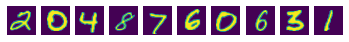

[1 1 1 0 0 0 1 0 1 1]


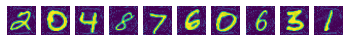

In [13]:
mx_pix_diff = np.abs(res["xs_test_pgd"] - res["ds_test"].xs).max() * 255
print(f"mx_pix_diff: {mx_pix_diff : .4f} / 255")

mx_l2_diff = np.linalg.norm(res["xs_test_pgd"] - res["ds_test"].xs, ord=2, axis=-1).max()
print(f"mx_l2_diff: {mx_l2_diff : .4f}\n")

dataset.plot_images(res["ds_test"], channels=1)

dataset.plot_images(
    dataset.Dataset(
        xs=res["xs_test_pgd"],
        ys=(res["preds_test_pgd"].flatten() >= 0).astype(int),
        one_hot=False,
        num_classes=10,
    ), channels=1
)

### RBF Rob. MNIST

In [38]:
EXP_PARAMS = ExperimentParams(
    ds_train=MNIST_TRAIN,#.prefix(32),
    ds_test=MNIST_TEST,#.prefix(64),
    num_fourier_features=4096,
    kernel_scale=10,#np.sqrt(1 / 1.28e-03 / 2.0),
    # 1 / (2 * (kernel_scale ** 2)) = gamma = 1.28e-03
    kernel_type="laplacian",
    train_epochs=300,
    adv_ratio=1,
    use_pgd=True,
    attack_norm=2,
    attack_eps=2,
    attack_eps_step=2/10,
    attack_iters=20,
    num_eval_per_epoch=512,  # How many samples to use during evaluation
    batch_size=512,
    learning_rate=3e-3,
    seed=42,
)

with mlflow.start_run() as _:
    res = run_experiment(EXP_PARAMS, print_every=1, verbose=True)

delta(eps)=1.204223e+00
PGD training with ratio 1 ...


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 0 finished; Evaling... {'loss': ' 1.0383', 'custom_acc': ' 0.3837'}
{'sub_train_pgd_loss': ' 1.0091', 'sub_train_pgd_custom_acc': ' 0.5020'}
{'sub_test_pgd_loss': ' 1.0103', 'sub_test_pgd_custom_acc': ' 0.5000'}
Epoch 1 finished; Evaling... {'loss': ' 1.0039', 'custom_acc': ' 0.5102'}
{'sub_train_pgd_loss': ' 0.9978', 'sub_train_pgd_custom_acc': ' 0.5176'}
{'sub_test_pgd_loss': ' 0.9957', 'sub_test_pgd_custom_acc': ' 0.5215'}
Epoch 2 finished; Evaling... {'loss': ' 1.0004', 'custom_acc': ' 0.5106'}
{'sub_train_pgd_loss': ' 1.0195', 'sub_train_pgd_custom_acc': ' 0.4863'}
{'sub_test_pgd_loss': ' 0.9827', 'sub_test_pgd_custom_acc': ' 0.5273'}
Epoch 3 finished; Evaling... {'loss': ' 0.9971', 'custom_acc': ' 0.5094'}
{'sub_train_pgd_loss': ' 0.9939', 'sub_train_pgd_custom_acc': ' 0.5117'}
{'sub_test_pgd_loss': ' 0.9543', 'sub_test_pgd_custom_acc': ' 0.5449'}
Epoch 4 finished; Evaling... {'loss': ' 0.9945', 'custom_acc': ' 0.5099'}
{'sub_train_pgd_loss': ' 1.0493', 'sub_train_pgd_custo

INFO:tensorflow:Assets written to: /tmp/tmpk6s1kove/model/data/model/assets


313/313 [==============================] - 2s 7ms/step - loss: 0.9801 - custom_acc: 0.5140


### Laplace Nat. MNIST

In [22]:
EXP_PARAMS = ExperimentParams(
    ds_train=MNIST_TRAIN,
    ds_test=MNIST_TEST,
    num_fourier_features=4096,
    kernel_scale=1 / 1.28e-03,
    # 1 / kernel_scale = gamma = 1.28e-03
    kernel_type="laplacian",
    train_epochs=95,
    adv_ratio=0,
    use_pgd=False,
    attack_norm=2,
    attack_eps=2.0,
    attack_eps_step=2.0/10,
    attack_iters=20,
    num_eval_per_epoch=512,  # How many samples to use during evaluation
    batch_size=512,
    learning_rate=3e-2,
    seed=42,
)

with mlflow.start_run() as _:
    res = run_experiment(EXP_PARAMS, print_every=5)

delta(eps)=1.430168e-01
Natural training...
Epoch 0 finished; Evaling... {'loss': ' 0.5029', 'custom_acc': ' 0.7875'}
Epoch 5 finished; Evaling... {'loss': ' 0.2673', 'custom_acc': ' 0.8978'}
Epoch 10 finished; Evaling... {'loss': ' 0.2434', 'custom_acc': ' 0.9073'}
Epoch 15 finished; Evaling... {'loss': ' 0.2240', 'custom_acc': ' 0.9152'}
Epoch 20 finished; Evaling... {'loss': ' 0.2131', 'custom_acc': ' 0.9193'}
Epoch 25 finished; Evaling... {'loss': ' 0.2074', 'custom_acc': ' 0.9222'}
Epoch 30 finished; Evaling... {'loss': ' 0.2011', 'custom_acc': ' 0.9231'}
Epoch 35 finished; Evaling... {'loss': ' 0.1940', 'custom_acc': ' 0.9261'}
Epoch 40 finished; Evaling... {'loss': ' 0.1894', 'custom_acc': ' 0.9284'}
Epoch 45 finished; Evaling... {'loss': ' 0.1827', 'custom_acc': ' 0.9317'}
Epoch 50 finished; Evaling... {'loss': ' 0.1869', 'custom_acc': ' 0.9288'}
Epoch 55 finished; Evaling... {'loss': ' 0.1791', 'custom_acc': ' 0.9324'}
Epoch 60 finished; Evaling... {'loss': ' 0.1770', 'custom_

INFO:tensorflow:Assets written to: /tmp/tmppbk6rpvn/model/data/model/assets


313/313 [==============================] - 2s 7ms/step - loss: 6.9398 - custom_acc: 0.0021


mx_pix_diff:  255.0000 / 255
mx_l2_diff:  1.5165

[0 0 0 1 1 1 0 1 0 0]


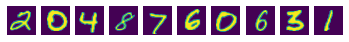

[1 1 1 0 0 0 1 0 1 1]


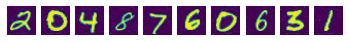

In [23]:
mx_pix_diff = np.abs(res["xs_test_pgd"] - res["ds_test"].xs).max() * 255
print(f"mx_pix_diff: {mx_pix_diff : .4f} / 255")

mx_l2_diff = np.linalg.norm(res["xs_test_pgd"] - res["ds_test"].xs, ord=2, axis=-1).max()
print(f"mx_l2_diff: {mx_l2_diff : .4f}\n")

dataset.plot_images(res["ds_test"], channels=1)

dataset.plot_images(
    dataset.Dataset(
        xs=res["xs_test_pgd"],
        ys=(res["preds_test_pgd"].flatten() >= 0).astype(int),
        one_hot=False,
        num_classes=10,
    ), channels=1
)